# Project for the 'Programming for Data Analysys'
***

### Table of content
[1. Problem statement](#par1)<br>
[2. Define functions used for process analysis](#par2)<br>
[3. Simulate the data using``numpy.random`` package](#par3)<br>
[3.1 Simulate single variable](#par3.1)<br>
[3.1.1 Perfect process](#par3.1.1)<br>
[3.1.1 Simulate 'special causes'](#par3.1.2)<br>
[3.2 Simulate scrap ratio based on 10 dimensions](#par3.2)<br>
[4. Analise the data](#par4)<br>
<hr>

### Import all the packages

In [1]:
# import all the packackes used in the notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import weibull_min, norm

In [2]:
# Create the new instance of the numpy psudorandom numbers Generator
rng = np.random.default_rng()

<a id="par1"></a>
## 1. Problem statement


Variability in any manufacturing process can be divided into two distinct categories [1]: 
- Random or natural variability, which is naturally present in any process or system. This can be caused by machine vibration, natural changes in raw material hardness, errors in machine axis encoders etc. Process that has only natural variability is called statistically stable process
- Assignable or special cause variability. This variability is not inherent part of the process and the sources of this variability can be identified and removed from the process.

In the Section 3.1.1. I will simaulate the result of a process that has only common causues of variability present. This type of proces can be described with a normal distribution 
Distribution of a measurements of a single dimension in the stable manufacturing process (process that has no special causes) follows normal distribution.

In Section 3.1.2 I will be adding special (or assignable) sources of process variability. First I will add batch to batch variation caused by changes in the fixture setup, next variability caused by the cutting tool: differences in the tool size, tool wear and tool failure.

The following assuptions were made:
- Single manufacturing process step is modelled
- Each part has 10 dimesnions that are separately measured
    - Some dimensions are correlated
- If any of the 10 dimensions is measured outside of the specified limit, part is scrapped
- Parts are manufactured in batches of 10

<a id="par2"></a>
## 2. Define functions used for process analysis

##### Define Histogram

In [3]:
def hist(data, label, lsl, usl, cp):
    # Calculate number of Histogram bins using Sturge’s Rule
    # as per: https://www.statisticshowto.com/choose-bin-sizes-statistics/
    bins = int(np.round(np.log10(n)*3.322+1))

    fig, ax = plt.subplots(1, 1)
    
    # Create a histogram, capture count to calculate position of the USL and LCL labels
    count, bins, patches = ax.hist(data, bins, density=False, label=label)
    
    max_y = max(count)
    
    # Draw red vertical lines for upper and lower tolerances
    ax.axvline(usl, color='r', linestyle='dashed', linewidth=1)
    ax.axvline(lsl, color='r', linestyle='dashed', linewidth=1)
    # Add labels to the vertical lines
    # https://stackoverflow.com/questions/13413112/creating-labels-where-line-appears-in-matplotlib-figure
    # y position of the label calculated using the count of the hihgest bin and divided by 10
    ax.text(lsl, max_y/10, 'LSL',rotation=90)
    ax.text(usl, max_y/10, 'USL',rotation=90)
    
    # Draw Probability density function for normal distribution
    
    # Get limit of the X axis
    # https://stackoverflow.com/questions/26131607/matplotlib-get-ylim-values
    x_min, x_max = ax.get_xlim()
    
    # https://realpython.com/how-to-use-numpy-arange/
    x = np.arange(x_min, x_max, (x_max-x_min)/500. )
    
    # calculate PDF using scipi.stats package:
    y = norm.pdf(x, loc=data.mean(), scale=data.std())
    
    # calculate the max bin count to max pdf ration to use it as scaling factor for pdf:
    scale = max_y/max(y)
    
    # Plot pdf
    ax.plot(x, y*scale)

    # define plot's parameters
    plt.rcParams["figure.figsize"] = [8, 4]
    plt.xlabel(' Dim1 measurement')
    plt.ylabel('Frequency of occurence')
    plt.title('Distribution of {} in a process with Cp={:.2}'.format(label, cp))
    plt.legend(['LSL', 'USL', 'PDF', label])
    plt.show()

##### Define SPC chart

In [4]:
# Define a function that will check if datapoints are violating any of the SPC rules
def spc_stats(dim):
    
    # Define DataFrame with one column 'Dim'
    data = pd.DataFrame({'Dim': dim})
    
    # Add column with moving range:
    # Calculated as per https://stackoverflow.com/questions/30673209/pandas-compare-next-row
    data['mR'] = data['Dim']-data['Dim'].shift(1)
    
    # Add 'Reason' column
    data['Reason'] = 0

    # calculate the mean of the variable
    x_bar = np.mean(data['Dim'])
    mr_bar = np.mean( np.abs(data['mR'][1:len(data['mR'])]))

    # Below calculations as per 'Implementing Six Sigma' Forrest W. Breyfogle III, p227
    # Calculate Upper and Lower Control Limits for X chart 
    ucl = x_bar+mr_bar*2.66
    lcl = x_bar-mr_bar*2.66

    # Calculate Upper Control Limits for mR chart (there is no lower CL for mR chart)
    mr_ucl = mr_bar+mr_bar*3.267    
    
    # Shewhart SPC control chart rules:
    # https://analyse-it.com/docs/user-guide/process-control/shewhart-control-chart-rules
    
    # Number of observation on the same side of the mean when the alarm is switched on (typically 8 or 9)
    n_side=8
    
    # Number of consecutive points steadily increasing or decreasing to switch the alarm (typically 6)
    n_drift = 6
    
    # Number of consecutive points are alternating up and down (typically 14)
    n_alter = 8
    
    # Check for measurements aoutside the contro limits
    for index, row in data.iterrows():
        x = row[0]
        mr = row[1]
        
        if x>ucl or x<lcl:
            data.loc[index, 'Reason'] = 1
            
        if mr>mr_ucl:
            data.loc[index, 'Reason'] = 2
            
    
    # check if there ar at least 'n_side' points on the same side of the mean line
    
    # 1 if point is above x_bar, -1 if it's below
    data['xbar_side'] = np.sign(data['Dim'] - x_bar)

    # count running sum of last n_side ['xbar_side'] values
    data['sameside'] = data['xbar_side']
    for i in range(1, n_side):
        data['sameside'] =  data['sameside']  + data['xbar_side'].shift(i)
    
    data.loc[ np.abs(data['sameside'])==n_side , 'Reason'] = 3
    
    # Check for drifts in data: points are steadily increasing or decreasing
    
    data['delta_sign']=np.sign( data['mR'] )
    
    # count running sum of last n_side ['xbar_side'] values
    data['drift'] = data['delta_sign']
    for i in range(1, n_drift):
        data['drift'] =  data['drift'] + data['delta_sign'].shift(i)
    
    data.loc[ np.abs(data['drift'])==n_drift , 'Reason'] = 4
    
    # check for consecutive points are alternating up and down
    
    # column 'alter' will be 0 if 2 consecutive points alter in direction of change
    # and will be 2 if they both going up or down
    data['alter'] = np.abs(data['delta_sign'] + data['delta_sign'].shift(1) )
    
    # if there sum of the last n_alter rows of 'alter' column equal 0
    # Then that means that these points were alternating up and down for n_alter consecutive points
    data['sum_alter'] = data['alter']
    for i in range(1, n_alter):
        data['sum_alter'] =  data['sum_alter'] + data['alter'].shift(i)
    
    data.loc[ np.abs(data['sum_alter'])==0 , 'Reason'] = 5    
    
    return data[['Dim', 'mR', 'Reason']], x_bar, mr_bar, ucl, lcl, mr_ucl
    #return data, x_bar, mr_bar, ucl, lcl, mr_ucl

In [5]:
def xmr(dim):
    # Below code for SPC chart originally taken from: https://towardsdatascience.com/quality-control-charts-guide-for-python-9bb1c859c051
    
    # Find the points that are violating SPC rules and calculate the means and control limits
    data, x_bar, mr_bar, ucl, lcl, mr_ucl = spc_stats(dim)


    # Plot x and mR charts
    fig, axs = plt.subplots(2, figsize=(8,8), sharex=True)

    # X chart
    # Graph all the points 
    axs[0].plot(data['Dim'], linestyle='-', marker='o', color='black')

    
    # Add red dot when there are too many points on the same side of the mean
    axs[0].plot(data[data['Reason']==5]['Dim'], linestyle="", marker='o', color='blue')     
    
    # Add red dot when there are too many points on the same side of the mean
    axs[0].plot(data[data['Reason']==4]['Dim'], linestyle="", marker='o', color='yellow')    
    
    # Add red dot when there are too many points on the same side of the mean
    axs[0].plot(data[data['Reason']==3]['Dim'], linestyle="", marker='o', color='orange')    
    
    # Add red dot where Dim is over UCL or under LCL
    axs[0].plot(data[data['Reason']==1]['Dim'], linestyle="", marker='o', color='red')    

    # Plot blue horizontal line at the process mean
    axs[0].axhline(x_bar, color='blue')

    # Plot red dotted lines at UCL and LCL
    axs[0].axhline(ucl, color = 'red', linestyle = 'dashed')
    axs[0].axhline(lcl, color = 'red', linestyle = 'dashed')

    # Set Chart title and axis labels
    axs[0].set_title('Individual Chart')
    axs[0].set(xlabel='Part', ylabel='Measurement')


    # mR chart
    # Graph all the points 
    axs[1].plot( np.abs(data['mR']), linestyle='-', marker='o', color='black')

    # Add red dot where Dim is over UCL
    axs[1].plot(data[data['Reason']==2]['mR'], linestyle="", marker='o', color='red')

    # Plot blue horizontal line at the mR mean
    axs[1].axhline(mr_bar, color='blue')

    # Plot red dotted line at UCL
    axs[1].axhline(mr_ucl, color='red', linestyle ='dashed')

    axs[1].set_ylim(bottom=0)
    axs[1].set_title('Moving Range Chart')
    axs[1].set(xlabel='Part', ylabel='Range')
    
    return data[data['Reason']>0]
    #return data

<a id="par3"></a>
## 3. Simulate the data using ```numpy.random``` package

<a id="par3.1"></a>
### 3.1 Simulate single variable

<a id="par3.1.1"></a>
#### 3.1.1 Process with no special cause variability

##### Define Dim1 attributes

Process capability:

$$
C_{p}=\frac{USL-LSL}{6\sigma}
$$

Given the process capability and upper and lower service limits, we can calculate the underlying process standard deviation:


$$
\sigma=\frac{USL-LSL}{6 C_{p}}
$$

##### Define process parameters

In [6]:
# Nominal dimension
mean = 9.5
# Upper and Lower tollerances
lsl, usl = 9.4, 9.6
# Process capability
cp = 2.
# Number of lots
nr_lots = 20
# Parts in the lot 
nr_in_lot = 10
# Total number of parts
n = nr_lots*nr_in_lot

In [7]:
# Simulate the measurements of single dimenension using normal distribution
# ccv stands for common cause variation
dim1 = pd.DataFrame({'ccv': rng.normal(mean, (usl-lsl)/(6*cp) , n)})

##### Show distribution of dim1 using Histogram

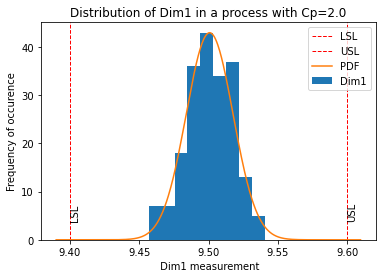

In [8]:
hist(dim1, 'Dim1', lsl, usl, cp)

##### Check Dim1 with Statistical Process Control charts

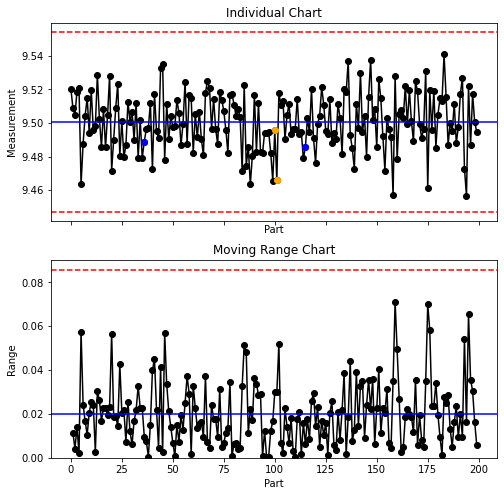

In [9]:
o = xmr(dim1.loc[:,'ccv'])

##### Process not centered at nominal

More realistic scenarion would be a situation where the manufacturing process is not perfectly centered on the nominal value. This can be caused by:
- Lack of machine calibration
- Poor process design

In [10]:
# Simulate the effect of proces not being centered at the nominal
# The mean of such process would be pooled from normal distribution:

proc_mean=rng.normal(mean, (usl-lsl)/6)

dim1['ccv'] = rng.normal(proc_mean, (usl-lsl)/(6*cp) , n)

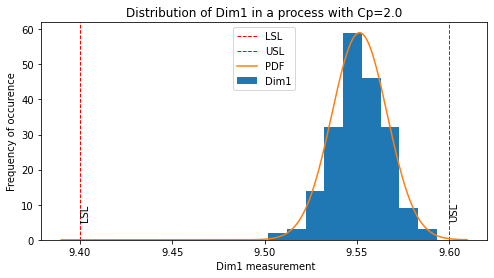

In [11]:
# As seen on the histogram plot, process without special causes variability is alredy not centered perfectly between upper and lower service limits
hist(dim1['ccv'], 'Dim1', lsl, usl, cp)

<a id="par3.1.2"></a>
#### 3.1.2 Simulate 'special causes'

##### Variation between the batches

Vatiation between the batches can be casued by:
- difrences in the fixture setup
- changes in the raw material (material hardness, forging size etc)

Distribution of batch-to-batch variation is normal.

In [12]:
# define the ratio of batch-to-batch standard deviation to the dimension tolerance
# The larger the number, the smallest the effect of this special cause 
btb_sd_ratio = 20

# create a array with adjustment for each lot
lots = rng.normal(0, (usl-lsl)/btb_sd_ratio , nr_lots)

# add the same adjustment for each 'nr_in_lot' in a lot
part = 0
for l in lots:
    for p in range(nr_in_lot):
        dim1.loc[part, 'btb'] = l
        part = part + 1


# Create a 'measured' column by adding a batch-to-batch variation to the base ccv dimensions
dim1['measured'] = dim1['ccv'] + dim1['btb']

# Show data for parts in 2 first lots to make sure btb is calculated correctly       
dim1.head(2*nr_in_lot)

,ccv,btb,measured
0,9.564780,-0.00671,9.558069
1,9.557811,-0.00671,9.551101
2,9.546885,-0.00671,9.540175
3,9.551647,-0.00671,9.544937
4,9.539439,-0.00671,9.532728
5,9.557709,-0.00671,9.550999
6,9.549646,-0.00671,9.542935
7,9.572300,-0.00671,9.565590
8,9.548954,-0.00671,9.542244
9,9.525283,-0.00671,9.518572


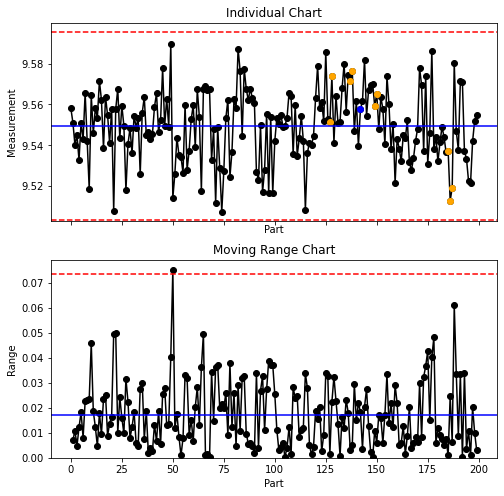

In [13]:
# Check the SPC chart for the measured dimension (common cause variation with batch-to-batch variation)
o = xmr(dim1.loc[:,'measured'])

##### Effect of the tool size variation

In [14]:
# define tool life: how many lots can be processed by one tool
lots_per_tool = 4
# tool tolerance
# Example tool tolerances: http://www.mitsubishicarbide.com/en/technical_information/tec_rotating_tools/face_mills/tec_milling_guide/tec_milling_tolerance
tool_tol = 0.02

In [15]:
# Distribution of changes in tool sizes will be pooled from uniform distribution from interval -tool_tol to 0
nr_of_tools = int(np.ceil(nr_lots/lots_per_tool))
tools = rng.uniform(-tool_tol, 0 , nr_of_tools)

# add the same adjustment to each part processed by one tool: lots_per_tool * nr_in_lot - lots_per_tool is in number of lots
part = 0
for t in tools:
    for p in range(nr_in_lot * lots_per_tool):
        dim1.loc[part, 'tcv'] = t
        part = part + 1
        # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
        # exiting the loop when part count reaches nr_lots*nr_in_lot
        if part==nr_lots*nr_in_lot:
            break

# Sum all the variations:
dim1['measured'] = dim1['ccv'] + dim1['btb'] + dim1['tcv']

<AxesSubplot:>

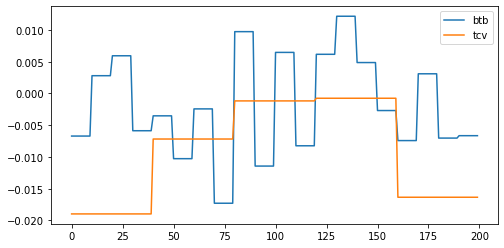

In [16]:
# Compare the impact from batch-to-batch variation with tool-change variation
dim1[['btb','tcv']].plot()

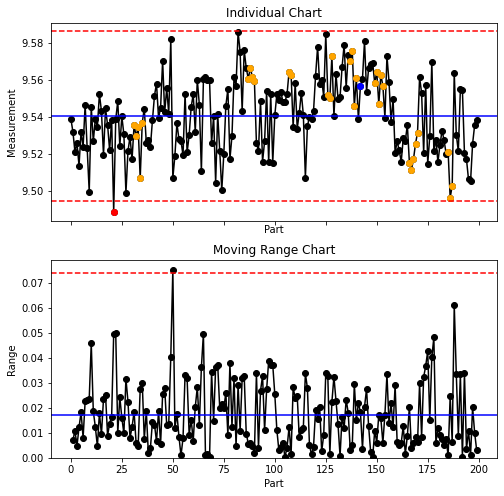

In [17]:
# Check the SPC chart for the measured dimension (common cause variation plus batch-to-batch variation and tool-change variation)
o = xmr(dim1.loc[:,'measured'])

##### Effect of a tool wear

In [18]:
# Tool wear can be aproximated with a linear model, as per:
# https://www.sciencedirect.com/science/article/pii/S235197891630049X/pdf?md5=de5447dd9c5745bc8a5638dc26d7d66c&pid=1-s2.0-S235197891630049X-main.pdf
# https://journals.sagepub.com/doi/pdf/10.1177/1687814017750434

# Define the maximum tool wear, assuming all tools wear with the same rate
max_tool_wear = 0.02

In [19]:
# Calculate the tool wear assuming linear tool-wear model
part = 0

for t in tools:
    for p in range(nr_in_lot * lots_per_tool):
        dim1.loc[part, 't_wear'] = p * max_tool_wear/(nr_in_lot * lots_per_tool)
        part = part + 1
        # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
        # exiting the loop when part count reaches nr_lots*nr_in_lot
        if part==nr_lots*nr_in_lot:
            break

dim1['measured'] = dim1['ccv'] + dim1['btb'] + dim1['tcv'] + dim1['t_wear']           

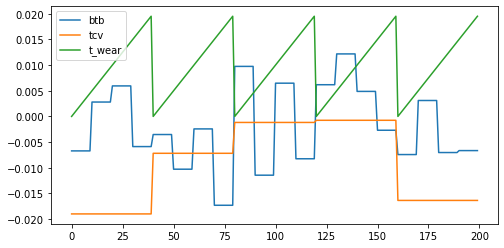

In [20]:
# Compare the impact from batch-to-batch variation, tool-change variation and tool wear
dim1[['btb','tcv', 't_wear']].plot()
plt.show()

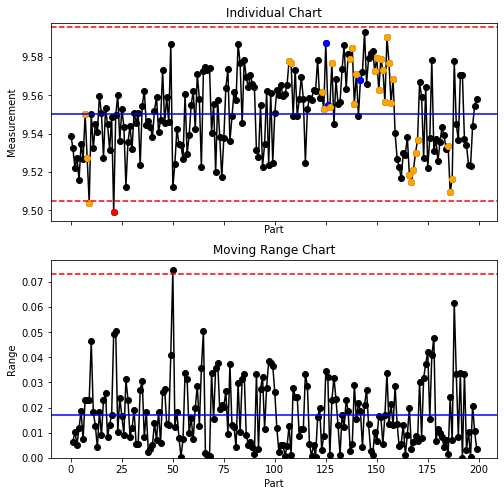

In [21]:
# Check the SPC chart for the measured dimension (common cause variation plus batch-to-batch variation and tool-change variation)
o = xmr(dim1.loc[:,'measured'])

##### Model tool failure

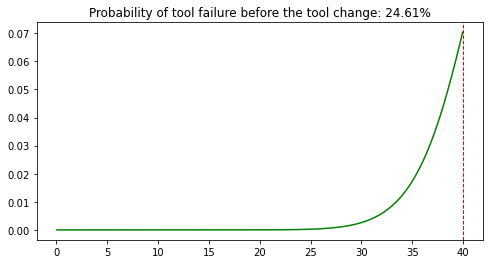

In [22]:
# Model number of parts machined by each tool using Weibull distribution
# https://www.researchgate.net/publication/226636244_Prediction_of_tool_failure_rate_in_turning_hardened_steels

# Shape parameter
a = 12
# scale parameter
lam = nr_in_lot * lots_per_tool  
# location parameter
mu = nr_in_lot * lots_per_tool * 0.1

# Round down to the nearest integer
tool_life = np.floor(weibull_min.rvs(a, loc=mu, scale=lam, size=nr_of_tools))

# define the x axis of the plot
x = np.arange(1, 1000.)/1000.*lam

y = weibull_min.pdf(x, a, loc=mu, scale=lam)
plt.plot(x, y, color='green', label='Scaled cdf')
plt.title('Probability of tool failure before the tool change: {:.2%}'.format(weibull_min.cdf(40, a, loc=mu, scale=lam)))
plt.axvline(nr_in_lot * lots_per_tool, color='r', linestyle='dashed', linewidth=1)
plt.show()

In [23]:
tool_life

array([40., 44., 41., 41., 36.])

In [24]:
part = 0

dim1['t_break'] = 0

for tl in tool_life:
    # if tool life is greater than number of parts processed by tool:
    if t>=nr_in_lot * lots_per_tool:
        part = part + nr_in_lot * lots_per_tool
        if part>=nr_lots*nr_in_lot:
            break        
    # if tool life is smaller than number of parts processed by tool:
    else:
        part = part + int(tl)
        if part>=nr_lots*nr_in_lot:
            break        
        for p in range(int(tl), nr_in_lot * lots_per_tool):
            # Assign random value from normal distribution centered around 0.1
            # Chipped cutting tool will have smaller size causing large shift in the machined size
            # but rougher edge will introduce more variation to the process
            dim1.loc[part, 't_break'] = rng.normal(0.1, 0.01)
            part = part + 1
            # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
            # exiting the loop when part count reaches nr_lots*nr_in_lot
            if part>=nr_lots*nr_in_lot:
                break
                
dim1['measured'] = dim1['ccv'] + dim1['btb'] + dim1['tcv'] + dim1['t_wear'] + dim1['t_break']     

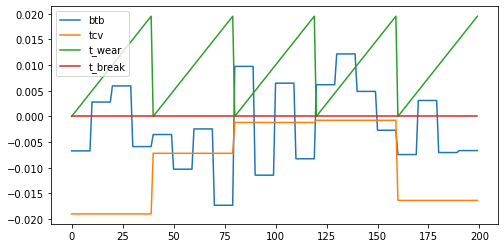

In [25]:
# Compare the impact from batch-to-batch variation, tool-change variation, tool wear and tool failure
dim1[['btb','tcv', 't_wear', 't_break']].plot()
plt.show()

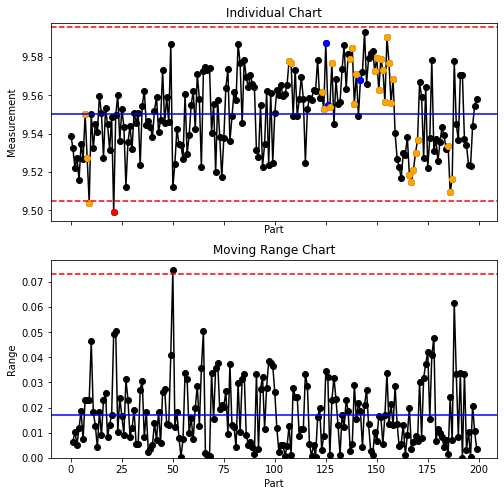

In [26]:
# Check the SPC chart for the measured dimension
o = xmr(dim1.loc[:,'measured'])

<a id="par3.1"></a>
### 3.2 Simulate 10 independent variables

#### 3.2.1 Create a table of process definitions

In [27]:
# Create a table of 10 process definitions:
# Number of independent variables to be simulated:
n_dim = 10

# list of typical tolerances used in manufacturing process and their typical frequency of use
tol_array = [0.02, 0.05, 0.10, 0.20]
tol_freq =  [0.10, 0.20, 0.50, 0.20]

dim_def = pd.DataFrame({'Nominal': np.round(rng.uniform(3, 10, n_dim), 1) })
dim_def['tolerance'] = rng.choice(tol_array, n_dim, p=tol_freq )
dim_def['LSL'] = dim_def['Nominal']-dim_def['tolerance']
dim_def['USL'] = dim_def['Nominal']+dim_def['tolerance']

dim_def['Cp'] = rng.normal(2, 0.5, n_dim)

dim_def

,Nominal,tolerance,LSL,USL,Cp
0,5.2,0.05,5.15,5.25,1.770785
1,6.0,0.05,5.95,6.05,2.803944
2,7.0,0.05,6.95,7.05,1.638820
3,3.9,0.02,3.88,3.92,1.890453
4,8.8,0.02,8.78,8.82,1.688941
5,6.8,0.10,6.70,6.90,2.147999
6,7.5,0.20,7.30,7.70,2.827989
7,5.4,0.20,5.20,5.60,2.111409
8,8.1,0.10,8.00,8.20,2.976605
9,3.3,0.10,3.20,3.40,1.850645


####  3.2.2 Create a table with dimension measurements for all the features

##### Define process step parameters

In [28]:
# Number of days
n_days = 30
# Numbers of batches (lots) manufactured in one day
nr_lots = 20
# Parts in a lot 
parts_in_lot = 10
# Total number of parts
n_parts = n_days* nr_lots * parts_in_lot

##### Prepare DataFrame to hold all the measurements

In [29]:
days = []

for day in range(n_days):
    for part in range(parts_in_lot * nr_lots):
        days.append(day)
        
all_dims = pd.DataFrame({'Date': days})
all_dims

,Date
0,0
1,0
2,0
3,0
4,0
...,...
5995,29
5996,29
5997,29
5998,29


In [30]:
# Simulate the n_dim number of features processed over n_days days:

for row, index in dim_def.iterrows():
    column = "Dim" + str(row + 1)
    mean = index[0]
    tol = index[1] * 2
    cp = index[4]
    
    # Simulate the effect of proces not being centered at the nominal
    # The mean of such process would be pooled from normal distribution:
    proc_mean=rng.normal(mean, tol/6)
    
    
    dim = pd.DataFrame({'ccv': rng.normal(proc_mean, tol/(6*cp) , n_parts)})
    
    # define the ratio of batch-to-batch standard deviation to the dimension tolerance
    # The larger the number, the smallest the effect of this special cause 
    btb_sd_ratio = 20

    # create an array with adjustment for each lot
    lots = rng.normal(0, tol/btb_sd_ratio , nr_lots * n_days)

    # add the same adjustment for each 'nr_in_lot' in a lot
    part = 0
    for l in lots:
        for p in range(parts_in_lot):
            dim.loc[part, 'btb'] = l
            part = part + 1


    # Create a 'measured' column by adding a batch-to-batch variation to the base ccv dimensions
    all_dims[column] = dim['ccv'] + dim['btb']        
    
    
    
all_dims    

,Date,Dim1,Dim2,Dim3,Dim4,Dim5,Dim6,Dim7,Dim8,Dim9,Dim10
0,0,5.184231,5.962074,6.954033,3.900127,8.802819,6.831300,7.515142,5.362489,8.096382,3.335234
1,0,5.175920,5.964446,6.982285,3.905498,8.803131,6.798417,7.478067,5.393266,8.108866,3.308876
2,0,5.187449,5.965950,6.966093,3.900061,8.807813,6.829425,7.540608,5.377616,8.089319,3.302226
3,0,5.171324,5.970351,6.963127,3.903507,8.805937,6.806304,7.506489,5.357204,8.072449,3.289620
4,0,5.177814,5.968991,6.966132,3.902858,8.807434,6.800118,7.546030,5.399743,8.098550,3.325531
...,...,...,...,...,...,...,...,...,...,...,...
5995,29,5.188558,5.967819,6.989139,3.904131,8.810893,6.795391,7.523071,5.331289,8.094529,3.270681
5996,29,5.179706,5.968904,6.965630,3.909160,8.817492,6.799086,7.500450,5.321426,8.105495,3.267959
5997,29,5.186639,5.952648,6.961028,3.900893,8.807506,6.841782,7.499782,5.337963,8.103131,3.279087
5998,29,5.194860,5.954364,6.986933,3.904805,8.807160,6.816518,7.541394,5.375275,8.092934,3.282426


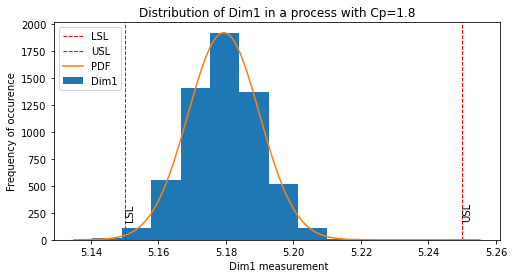

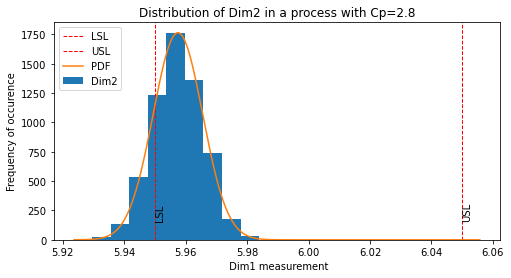

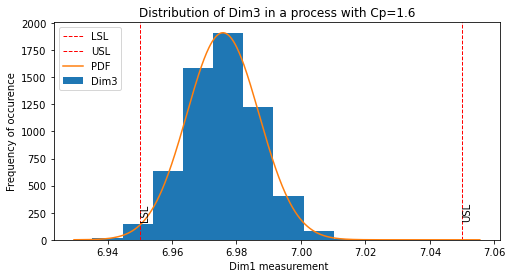

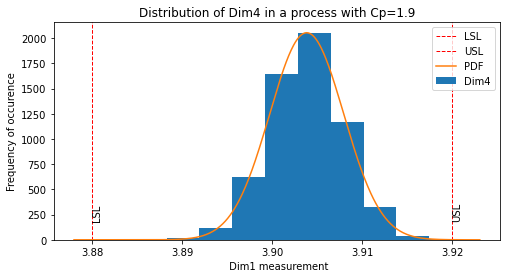

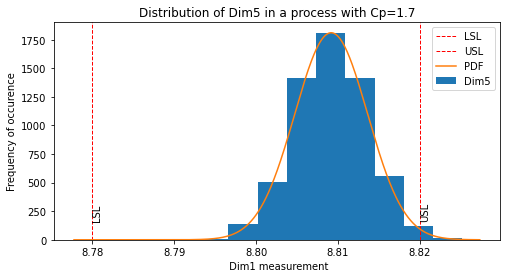

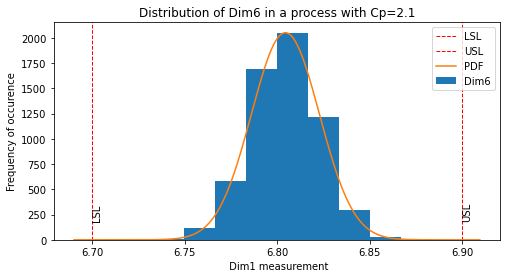

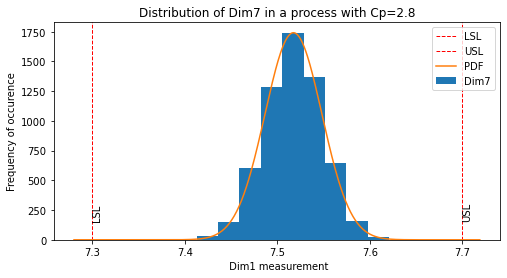

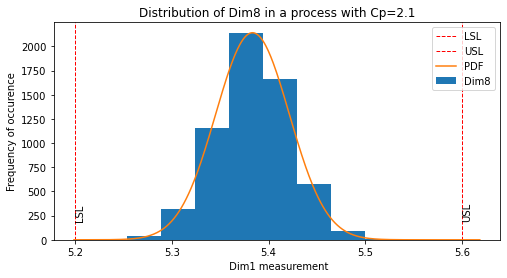

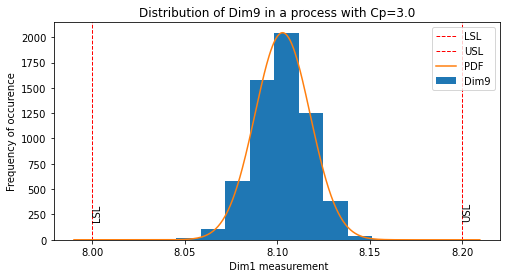

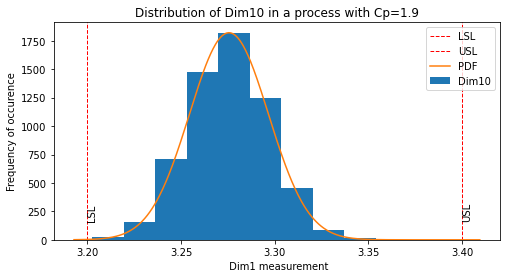

In [31]:
# Show all the dimensions distribution on histogram with LSL and USL marked
for row, index in dim_def.iterrows():
    column = "Dim" + str(row + 1)
    hist(all_dims[column], column, dim_def.loc[row,'LSL'], dim_def.loc[row,'USL'], dim_def.loc[row,'Cp'])

<a id="par4"></a>
## 4. Analyse the data

## 5. References

[[1] VARIABILITY IN MANUFACTURING](https://link.springer.com/referenceworkentry/10.1007%2F1-4020-0612-8_1032#Chap1031_1-4020-0612-8_1031)<br>

# End